In [1]:
# We will be using satimage data as in the Borderline-SMOTE paper
from sklearn.datasets import fetch_openml
import pandas as pd
import gc

data = fetch_openml(name='satimage')
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

# treat 4 as the target class
y = (y=='4.').astype(int)
y.mean()

del data
gc.collect()

0

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                    stratify=y, shuffle=True, random_state=1024)

def evaluate(clf):
    pred_proba = clf.predict_proba(X_test)[:, 1]
    pred = clf.predict(X_test)
    metric = 'AUC: {}\nRecall: {}\nPrecision: {}\nF1: {}\n'.format(roc_auc_score(y_test, pred_proba),
                                                              recall_score(y_test, pred),
                                                              precision_score(y_test, pred),
                                                              f1_score(y_test, pred))
    print(metric)
    
clf = RandomForestClassifier(n_estimators=100, random_state=1024)

In [12]:
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
import tensorflow_probability as tfp


ds = tfp.distributions

In [7]:
def standardize(x):
    mean_, var_ = tf.nn.moments(x, axes=[0], keepdims=True)
    return (x - mean_) / tf.sqrt(var_)

In [154]:
N_FEATURE = X_train.shape[1]
BATCH_SIZE = 124

train_dataset = tf.data.Dataset.from_tensor_slices(X_train.values.astype('float32')) \
    .shuffle(10000).batch(BATCH_SIZE).map(standardize)
test_dataset = tf.data.Dataset.from_tensor_slices(X_test.values.astype('float32')) \
    .shuffle(10000).batch(10000).map(standardize)

# all positive samples
train_pos_dataset = tf.data.Dataset.from_tensor_slices(X_train[y_train==1].values.astype('float32')) \
    .shuffle(10000).batch(BATCH_SIZE).map(standardize)
test_pos_dataset = tf.data.Dataset.from_tensor_slices(X_test[y_test==1].values.astype('float32')) \
    .shuffle(10000).batch(10000).map(standardize)

In [150]:
sample = next(iter(train_dataset))
sample.shape

TensorShape([124, 36])

In [151]:
def make_encoder_decoder(hidden_size=4, share_hidden=False):
    """ If share hidden is set to False, then the actual hidden_size will be 2 * hidden_size
        and it will split in half into the mean and std vector
    """
    if share_hidden is False:
        hidden_size = hidden_size * 2
        
    encoder = tf.keras.models.Sequential([
        keras.layers.InputLayer(input_shape=(N_FEATURE,)),
        keras.layers.Dense(36, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(18, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(hidden_size)
    ])

    decoder = tf.keras.models.Sequential([
        keras.layers.Dense(18, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(36, activation=None),
        keras.layers.LeakyReLU(alpha=0.2),
        keras.layers.Dense(N_FEATURE)
    ])
    
    return encoder, decoder

In [156]:
def make_discriminator():
    inputs = keras.layers.Input(shape=(N_FEATURE,))
    layer_1 = keras.layers.Dense(36, activation='relu')(inputs)
    layer_2 = keras.layers.Dense(18, activation='relu')(layer_1)
    layer_3 = keras.layers.Dense(8, activation='relu')(layer_2)
    out = keras.layers.Dense(1)(layer_3)
    return keras.models.Model(inputs=[inputs], outputs=[layer_2, out])

In [157]:
class VAEGAN(keras.Model):
    
    def __init__(self, lr_gen=1e-3, 
                 lr_disc=1e-4, 
                 hidden_size=4, 
                 share_hidden=False,
                 latent_loss_div=1,
                 sig_mult = 10,
                 recon_loss_div = 0.001):
        super().__init__()
        self.encoder, self.decoder = make_encoder_decoder(hidden_size=hidden_size, 
                                                          share_hidden=share_hidden)
        self.discriminator = make_discriminator()
        self.hidden_size = hidden_size
        self.share_hidden = share_hidden
        self.lr_gen = lr_gen
        self.lr_disc = lr_disc
        self.latent_loss_div = latent_loss_div
        self.sig_mult = sig_mult
        self.recon_loss_div = recon_loss_div
        
        self.enc_opt = keras.optimizers.Adam(self.lr_gen, beta_1=0.5)
        self.dec_opt = keras.optimizers.Adam(self.lr_gen, beta_1=0.5)
        self.disc_opt = keras.optimizers.Adam(self.get_lr_disc, beta_1=0.5)
    
    def get_lr_disc(self):
        return self.lr_disc * self.D_prop
        
    def encode(self, x):
        encoded = self.encoder(x)
        if self.share_hidden:
            mu, sigma = self.dense_mean(encoded), self.dense_std(encoded)
        else:
            mu, sigma = tf.split(encoded, num_or_size_splits=2, axis=1)
        return mu, sigma, ds.MultivariateNormalDiag(loc=mu, scale_diag=sigma)
    
    def decode(self, z):
        return self.decoder(z)
    
    def discriminate(self, x):
        return self.discriminator(x)
    
    @staticmethod
    def gan_loss(logits, is_real=True):
        if is_real:
            labels = tf.ones_like(logits)
        else:
            labels = tf.zeros_like(logits)
        return tf.reduce_mean(keras.losses.binary_crossentropy(labels, logits))

    @staticmethod
    def sigmoid(x, shift=0.0, mult=20):
        """ squashes a value with a sigmoid """
        return tf.constant(1.0) / (
            tf.constant(1.0) + tf.exp(-tf.constant(1.0) * (x * mult))
        )
    
#     @tf.function
    def compute_loss(self, x):
        mu, sigma, q_z = self.encode(x)
        z_real = q_z.sample()
        regen_real = self.decode(z_real)
        
        p_z = ds.MultivariateNormalDiag(loc=[0.0] * z_real.shape[-1], 
                                        scale_diag=[1.0] * z_real.shape[-1])
        # we add mu and sigma back, so the discriminator couldn't just tell from the scale of the features
        z_fake = p_z.sample(sample_shape=z_real.shape[0]) * sigma + mu
        regen_fake = self.decode(z_fake)
        
        middle_layer_origin, disc_origin = self.discriminate(x)
        middle_layer_real, disc_real = self.discriminate(regen_real)
        middle_layer_fake, disc_fake = self.discriminate(regen_fake)
        
        # losses
        disc_real_loss = self.gan_loss(disc_origin, True)
        disc_fake_loss = self.gan_loss(disc_fake, False)
        gen_fake_loss = self.gan_loss(disc_fake, True)
        
        disc_layer_recon_loss = tf.reduce_mean(
            tf.reduce_mean((middle_layer_origin - middle_layer_real)**2, axis=0)) / self.recon_loss_div
        
        self.D_prop = self.sigmoid(disc_fake_loss - gen_fake_loss, shift=0.0, mult=self.sig_mult)
        
        kl_div = ds.kl_divergence(q_z, p_z)
        latent_loss = tf.reduce_mean(tf.maximum(kl_div, 0)) / self.latent_loss_div
        
        return self.D_prop, latent_loss, disc_layer_recon_loss, gen_fake_loss, disc_fake_loss, disc_real_loss
    
#     @tf.function
    def compute_gradients(self, x):
        with tf.GradientTape() as enc_tape, tf.GradientTape() as dec_tape, tf.GradientTape() as disc_tape:
            (
                _,
                latent_loss,
                discrim_layer_recon_loss,
                gen_fake_loss,
                disc_fake_loss,
                disc_real_loss,
            ) = self.compute_loss(x)

            enc_loss = latent_loss + discrim_layer_recon_loss
            dec_loss = gen_fake_loss + discrim_layer_recon_loss
            disc_loss = disc_fake_loss + disc_real_loss

        enc_gradients = enc_tape.gradient(enc_loss, self.encoder.trainable_variables)
        dec_gradients = dec_tape.gradient(dec_loss, self.decoder.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)
        return enc_gradients, dec_gradients, disc_gradients
    
    def apply_gradients(self, enc_gradients, dec_gradients, disc_gradients):
        self.enc_opt.apply_gradients(
            zip(enc_gradients, self.encoder.trainable_variables)
        )
        self.dec_opt.apply_gradients(
            zip(dec_gradients, self.decoder.trainable_variables)
        )
        self.disc_opt.apply_gradients(
            zip(disc_gradients, self.discriminator.trainable_variables)
        )

    def train(self, x):
        enc_gradients, dec_gradients, disc_gradients = self.compute_gradients(x)
        self.apply_gradients(enc_gradients, dec_gradients, disc_gradients)

In [158]:
# create model
model = VAEGAN(latent_loss_div=1.0, recon_loss_div=0.05)

# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns=[
    'd_prop',
    'latent_loss',
    'discrim_layer_recon_loss',
    'gen_fake_loss',
    'disc_fake_loss',
    'disc_real_loss',
])

n_epochs = 1000
N_TRAIN_BATCHES = y_train.sum() // BATCH_SIZE
N_TEST_BATCHES = y_test.sum() // BATCH_SIZE

for epoch in tqdm(range(n_epochs)):
    # train
    for batch, train_x in zip(range(N_TRAIN_BATCHES), train_pos_dataset):
        model.train(train_x)
        
    # test on holdout
    loss = []
    for batch, test_x in zip(range(N_TEST_BATCHES), test_pos_dataset):
        loss.append(model.compute_loss(test_x))
    
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    print(
        "Epoch: {}".format(epoch)
    )

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82
Epoch: 83
Epoch: 84
Epoch: 85
Epoch: 86
Epoch: 87
Epoch: 88
Epoch: 89
Epoch: 90
Epoch: 91
Epoch: 92
Epoch: 93
Epoch: 94
Epoch: 95
Epoch: 96
Epoch: 97
Epoch: 98
Epoch: 99
Epoch: 100

Epoch: 754
Epoch: 755
Epoch: 756
Epoch: 757
Epoch: 758
Epoch: 759
Epoch: 760
Epoch: 761
Epoch: 762
Epoch: 763
Epoch: 764
Epoch: 765
Epoch: 766
Epoch: 767
Epoch: 768
Epoch: 769
Epoch: 770
Epoch: 771
Epoch: 772
Epoch: 773
Epoch: 774
Epoch: 775
Epoch: 776
Epoch: 777
Epoch: 778
Epoch: 779
Epoch: 780
Epoch: 781
Epoch: 782
Epoch: 783
Epoch: 784
Epoch: 785
Epoch: 786
Epoch: 787
Epoch: 788
Epoch: 789
Epoch: 790
Epoch: 791
Epoch: 792
Epoch: 793
Epoch: 794
Epoch: 795
Epoch: 796
Epoch: 797
Epoch: 798
Epoch: 799
Epoch: 800
Epoch: 801
Epoch: 802
Epoch: 803
Epoch: 804
Epoch: 805
Epoch: 806
Epoch: 807
Epoch: 808
Epoch: 809
Epoch: 810
Epoch: 811
Epoch: 812
Epoch: 813
Epoch: 814
Epoch: 815
Epoch: 816
Epoch: 817
Epoch: 818
Epoch: 819
Epoch: 820
Epoch: 821
Epoch: 822
Epoch: 823
Epoch: 824
Epoch: 825
Epoch: 826
Epoch: 827
Epoch: 828
Epoch: 829
Epoch: 830
Epoch: 831
Epoch: 832
Epoch: 833
Epoch: 834
Epoch: 835
Epoch: 836
Epoch: 837
Epoch: 838
Epoch: 839
Epoch: 840
Epoch: 841
Epoch: 842
Epoch: 843
Epoch: 844

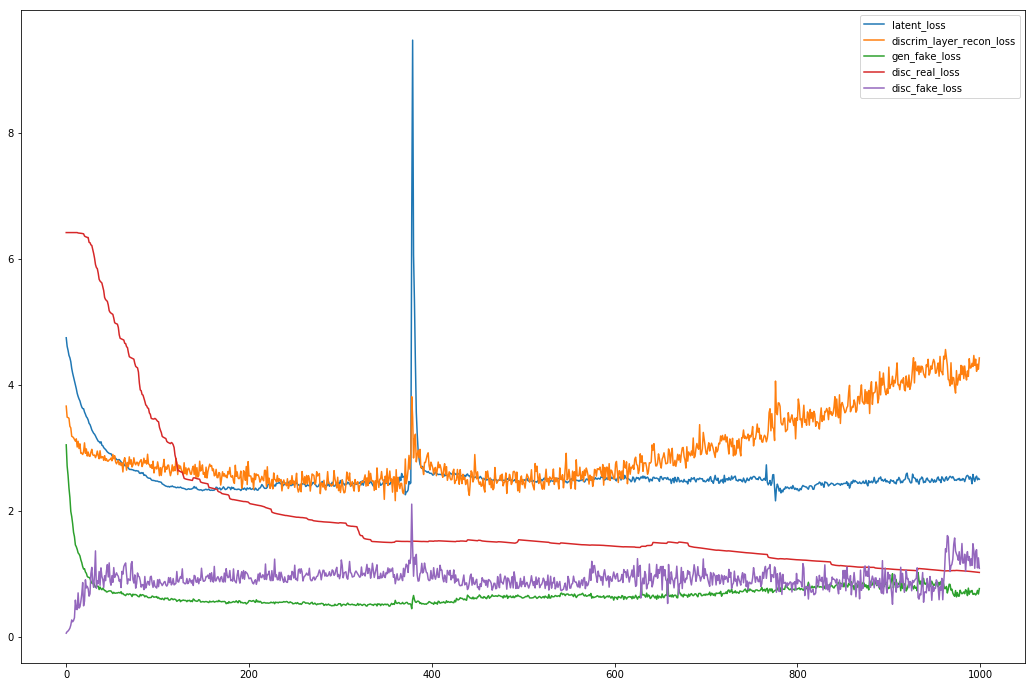

In [159]:
# plot the loss throughout the training
import matplotlib.pyplot as plt
%matplotlib inline

_ = plt.subplots(figsize=(18, 12))
plt.plot(losses.index, losses.latent_loss, label='latent_loss')
plt.plot(losses.index, losses.discrim_layer_recon_loss, label='discrim_layer_recon_loss')
plt.plot(losses.index, losses.gen_fake_loss, label='gen_fake_loss')
plt.plot(losses.index, losses.disc_real_loss, label='disc_real_loss')
plt.plot(losses.index, losses.disc_fake_loss, label='disc_fake_loss')
plt.legend()
plt.show()

In [162]:
# number of positive samples to generate so the minority class has the same amount as majority clas
n = (y_train == 0).sum() - (y_train==1).sum()
print('Need to generate {} positive samples.'.format(n))

Need to generate 3627 positive samples.


In [164]:
X_train_pos = X_train[y_train==1]

_, _, ds_pos = model.encode(X_train_pos.values)
sample_pos = ds_pos.sample(sample_shape=(n // y_train.sum()) + 1, seed=1024)
sample_pos = tf.reshape(sample_pos, [-1, model.hidden_size])
sample_pos = model.decode(sample_pos)
sample_pos.shape

TensorShape([3933, 36])

In [165]:
# append new samples to original samples
X_ = np.r_[X_train.values, sample_pos.numpy()[:n, ...]]
y_ = np.append(y_train, [1] * n)

# shuffle it 
from sklearn.utils import shuffle
X_, y_ = shuffle(X_, y_, random_state=1024)

In [166]:
clf.fit(X_, y_)

evaluate(clf)

AUC: 0.9504396470602613
Recall: 0.48936170212765956
Precision: 0.8288288288288288
F1: 0.6153846153846154

